In [1]:
# Set up imports
import xarray as xr
from pystac_client import Client
import stackstac


# Exploring STAC catalogs using Python

STAC is a specification for describing spatiotemporal data assets, intended to facilite search and discovery of relevant data, especially based on spatial and/or temporal queries of interest.

## CEDA STAC API

STAC API provided by the Centre for Environmental Data Analysis (UK)

STAC Browser: https://stac.ceda.ac.uk/?.language=en

First we open a connection to the root-level catalog...

In [2]:
uri = 'https://api.stac.ceda.ac.uk/'
catalog = Client.open(uri)
catalog

<Client id=ceda-stac-catalogue>

Now grab all the collections in the catalog, and print out a list of the IDs and names.

In [3]:
collections = catalog.get_all_collections()
for collection in collections:
    print(f'[{collection.id}]: {collection.title}')

[DYAMOND3_N2560]: DYAMOND3 N2560 STAC Index
[cci]: CCI
[cmip6]: CMIP6
[cordex]: CORDEX
[eocis-aerosol-slstr-daily-s3a]: EOCIS AEROSOL from Sentinel 3A daily
[eocis-aerosol-slstr-daily-s3b]: EOCIS AEROSOL from Sentinel 3B daily
[eocis-aerosol-slstr-monthly-s3a]: EOCIS AEROSOL from Sentinel 3A monthly
[eocis-aerosol-slstr-monthly-s3b]: EOCIS AEROSOL from Sentinel 3B monthly
[eocis-arctic-sea-ice-thickness-monthly]: EOCIS Arctic Monthly Gridded Sea Ice Thickness Product from CryoSat-2
[eocis-lst-s3a-day]: EOCIS Land Surface Temperature from Sentinel 3A daily (day)
[eocis-lst-s3a-night]: EOCIS Land Surface Temperature from Sentinel 3A daily (night)
[eocis-lst-s3b-day]: EOCIS Land Surface Temperature from Sentinel 3B daily (day)
[eocis-lst-s3b-night]: EOCIS Land Surface Temperature from Sentinel 3B daily (night)
[eocis-sst-cdrv3]: EOCIS Sea-Surface Temperatures V3
[land_cover]: ESA Land Cover Climate Change Initiative (CCI): Global Land Cover Maps
[sentinel1]: Sentinel-1 Single Look Complex

Let's look closer at the monthly Arctic sea ice thickness collection.

In [4]:
ice_collection_id = 'eocis-arctic-sea-ice-thickness-monthly'
ice_collection = catalog.get_collection(ice_collection_id)
ice_collection

<CollectionClient id=eocis-arctic-sea-ice-thickness-monthly>

This particular catalog supports `search` requests, so let's do a first search that looks for all items in the ice collection.

In [5]:
ice_item_collection = catalog.search(
        collections=[ice_collection.id]
    ).item_collection()

print(f'Returned {len(ice_item_collection)} items')
print('First 5 items:')
ice_item_collection.items[:5]

Returned 99 items
First 5 items:


[<Item id=ea60feff-3a21-49d1-b79f-9179c052cfc0>,
 <Item id=f2a5764b-5f1e-4011-a8c2-d1eb75995d3b>,
 <Item id=d3ee4814-f522-4bf9-99d6-45bff8018cec>,
 <Item id=113583bf-a0d3-499d-9252-ea6ec096abe7>,
 <Item id=8d23432c-9f46-4ae9-9854-27b880d675f3>]

Now let's use the bread-and-butter of STAC. We'll repeat the search, now applying a combination of spatial and temporal constraints to further limit the results. This just tells you what overlaps, not what is _only_ within the bounds specified.

In [6]:
ice_item_subset = catalog.search(
    collections=[ice_collection.id],
    bbox=[-157.223175, 71.134346, -155.816925, 71.388457],
    datetime='2020'
).item_collection()

print(f'Retrieved {len(ice_item_subset)} items for collection {ice_collection.id}')
ice_item_subset

Retrieved 7 items for collection eocis-arctic-sea-ice-thickness-monthly


Note that we can retrieve an item by ID from the collection, where the collection has been retrieve by ID from the catalog.

In [7]:
ice_item = catalog \
    .get_collection(ice_collection.id) \
    .get_item('ea60feff-3a21-49d1-b79f-9179c052cfc0')
ice_item

<Item id=ea60feff-3a21-49d1-b79f-9179c052cfc0>

Click into the `assets` in the entry above. It's a `kerchunk.json` "dataset"! In a nutshell, this is a Zarr store in which the data references point "into" linked netCDF files, with byte ranges corresponding to the segments of the file holding the relevant "chunks" of interest. Everything connects :)

In [9]:
import fsspec
import json
fs = fsspec.filesystem('http')

kerchunk_href = ice_item.assets['reference_file'].href
with fs.open(kerchunk_href) as f:
    print(json.dumps(json.load(f), indent=2))

{
  "version": 1,
  "refs": {
    ".zgroup": "{\"zarr_format\":2}",
    ".zattrs": "{\"Conventions\":\"CF-1.10\",\"conventions\":\"CF-1.10\",\"creator_name\":\"Andy Ridout, Alan Muir (CPOM, University College London)\",\"creator_url\":\"http:\\/\\/www.cpom.org.uk\",\"date_created\":\"20250114T095946Z\",\"end_day\":\"30\",\"end_month\":\"11\",\"end_year\":\"2024\",\"geospatial_lat_max\":\"88.2284\",\"geospatial_lat_min\":\"67.1128\",\"geospatial_lon_max\":\"359.9999\",\"geospatial_lon_min\":\"0.0002\",\"geospatial_vertical_max\":\"0.0\",\"geospatial_vertical_min\":\"0.0\",\"institution\":\"Centre for Polar Observation and Modelling (CPOM), U.K\",\"keywords\":\"Sea Ice, Thickness, Radar Altimeters\",\"license\":\"Creative Commons Attribution 4.0 International (CC BY 4.0)\",\"ndays\":\"30\",\"platform\":\"CryoSat-2\",\"processing_level\":\"Level-3C\",\"project\":\"EOCIS\",\"sensor\":\"SIRAL\",\"spatial_resolution\":\"5 km\",\"standard_name_vocabulary\":\"CF\",\"start_day\":\"1\",\"start_m

# Discover Sentinel COGs and create a stack

Hat tip: This tutorial is based on https://www.geodose.com/2024/02/pystac-decoded-step-by-step-tutorial.html

See online browser: https://stacindex.org/catalogs/earth-search#/

First let's connect to the top-level catalog

In [10]:
uri = 'https://earth-search.aws.element84.com/v1'
catalog = Client.open(uri)
catalog

<Client id=earth-search-aws>

Now we'll see what collections are stored at that Catalog level

In [11]:
collection_list = list(catalog.get_collections())
print(f"Catalog contains {len(collection_list)} collections")
for collection in collection_list:
    print(f'- [{collection.id}] {collection.title}')

Catalog contains 9 collections
- [sentinel-2-pre-c1-l2a] Sentinel-2 Pre-Collection 1 Level-2A 
- [cop-dem-glo-30] Copernicus DEM GLO-30
- [naip] NAIP: National Agriculture Imagery Program
- [cop-dem-glo-90] Copernicus DEM GLO-90
- [landsat-c2-l2] Landsat Collection 2 Level-2
- [sentinel-2-l2a] Sentinel-2 Level-2A
- [sentinel-2-l1c] Sentinel-2 Level-1C
- [sentinel-2-c1-l2a] Sentinel-2 Collection 1 Level-2A
- [sentinel-1-grd] Sentinel-1 Level-1C Ground Range Detected (GRD)


Let's dive into the `sentinel-2-l2a` collection.

In the returned widget, look at some of the details. Especially take note of:
- **extent**: Note the information about the _spatial_ and _temporal_ coverage of this collection. This is central to STAC!
- **item_asset**
- ... and more ...

In [12]:
sentinel_collection_id = 'sentinel-2-l2a'
catalog.get_collection(sentinel_collection_id)

<CollectionClient id=sentinel-2-l2a>

What does this collection contain? For starts ... how big is the collection, in terms of the number of items?

Here's a trick to get a total item count: We do an search on the catalog, specifically referencing the collection of interest, but otherwise not providing any query constraints. Importantly, we'll tell this method not to return any items. Then we'll invoke the `matched()` method on this returned object, reporting the total count of "matched" items -- which in this case is the total count of items in the collection

In [13]:
n = catalog.search(collections=[sentinel_collection_id], max_items=0).matched()
print(f'Found {n:,} items in the {sentinel_collection_id} collection')

Found 39,958,287 items in the sentinel-2-l2a collection


In [ ]:
# For a smaller collection, we could bring back all of the item information 
# in a list. But for 40M, we don't want to do this :)
# [item.id for item in catalog.get_collection('sentinel-2-l2a').get_items()]

Now let's get down to the **item** level. Quoting the STAC spec (with emphasis added):
>An Item is a GeoJSON Feature augmented with foreign members relevant to a STAC object. These include fields that identify the time range and assets of the Item. **An Item is the core object in a STAC Catalog**, containing the core metadata that enables any client to search or crawl online catalogs of spatial 'assets' (e.g., satellite imagery, derived data, DEMs).


To retrieve some items, we'll go back to the `catalog.search()` method, but this time providing some significant restrictions on what we want. In particular, we'll limit by **geographic extent** using a (hand-created) bounding box corresponding to a small area near Utqiagvik, and by temporal extent using a date range spanning a few months.

In [14]:
# https://linestrings.com/bbox/#-156.8,71.25,-156.7,71.3
east, west, north, south = -156.7, -156.8, 71.3, 71.25
bbox_utqiagvik = [west, south, east, north]

item_collection = catalog.search(
    #intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=[sentinel_collection_id],
    bbox = bbox_utqiagvik,
    datetime="2020-03-01/2020-06-01"        # this is asking for a range of dates
).item_collection()

print(f'Returned {len(item_collection)} items')


Returned 148 items


In [15]:
for item in item_collection.items[:10]:
    print(item.id,":", item.properties['datetime'])

S2B_4WEE_20200601_1_L2A : 2020-06-01T22:25:51.010000Z
S2B_4WEE_20200601_0_L2A : 2020-06-01T22:25:51.006000Z
S2B_4WEE_20200531_1_L2A : 2020-05-31T22:55:45.656000Z
S2B_4WEE_20200531_0_L2A : 2020-05-31T22:55:45.651000Z
S2A_4WEE_20200530_1_L2A : 2020-05-30T22:35:54.178000Z
S2A_4WEE_20200530_0_L2A : 2020-05-30T22:35:54.177000Z
S2B_4WEE_20200528_1_L2A : 2020-05-28T22:45:47.375000Z
S2B_4WEE_20200528_0_L2A : 2020-05-28T22:45:47.373000Z
S2A_4WEE_20200527_1_L2A : 2020-05-27T22:25:55.406000Z
S2A_4WEE_20200527_0_L2A : 2020-05-27T22:25:55.404000Z


Let's have a look at the first item. Now the specific geographic extent of the associated item assets are recorded in the **geometry** and **bbox** entries, and the temporal information is stored in **properties -> datetime**.

In [16]:
item_collection.items[0]

<Item id=S2B_4WEE_20200601_1_L2A>

Remember, STAC items are still _catalog entries_, not the underlying data or other artifact! STAC doesn't actually store data, but like any useful catalog, it tells you were to find. In STAC parlance, the "things" it refers to are called **assets**, which "belong" to an item. An item can refer to many assets. You can see them under the **assets** intry in the catalog visualizer above, or access them in a dictionary-like way using the `assets` accessor on the item.

In [17]:
item_collection.items[0].assets['nir']

<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/4/W/EE/2020/6/S2B_4WEE_20200601_1_L2A/B08.tif>

From the information above, we can see that the _nir_ reflectance data artifact corresponding to this asset is stored as a cloud-optimized GeoTIFF in AWS S3 storage. We can take the individual COG URL and throw it in [this cool interactive COG web mapper site](https://cholmes.github.io/cog-map/#/url/https%3A%2F%2Fsentinel-cogs.s3.us-west-2.amazonaws.com%2Fsentinel-s2-l2a-cogs%2F4%2FW%2FEE%2F2020%2F6%2FS2B_4WEE_20200601_1_L2A%2FB08.tif/center/-155.658,70.152/zoom/6.2), and could of course load this into Python using `rasterio` or `rioxarray`, depending on our preference.

Here's an example using xarrarry

In [18]:
import rioxarray

href = "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/4/W/EE/2020/6/S2B_4WEE_20200601_1_L2A/B08.tif"
rx_nir = rioxarray.open_rasterio(href, chunks={})
# could also use xr.open_dataarray(href, engine='rasterio', chunks='auto')

rx_nir


<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
dask.array<open_rasterio-cc742d41aa927c319a0e969c9c370d79<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 10980, 10980), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 8e+06 8e+06 8e+06 ... 7.89e+06 7.89e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

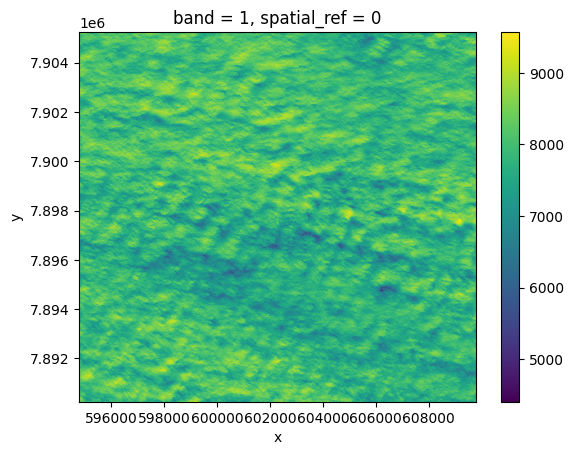

In [19]:
rx_nir.squeeze()[-1500:, -1500:].plot.imshow();

But what if we want to assemble a bunch of COGs for different dates? We could do it manually. Or ... `stackstac` to the rescue!

From [their documentation](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html), here's what `stackstac` does for you:
> - Figure out the geospatial parameters from the STAC metadata (if possible): a coordinate reference system, resolution, and bounding box.
> - Transfer the STAC metadata into xarray coordinates for easy indexing, filtering, and provenance of metadata.
> - Efficiently generate a Dask graph for loading the data in parallel.
> - Mediate between Dask’s parallelism and GDAL’s aversion to it, allowing for fast, multi-threaded reads when possible, and at least preventing segfaults when not.

FYI: There's another project, `ods.stac` that does something similar. Check out _their_ [documentation](https://odc-stac.readthedocs.io/en/latest/).

TBD which one wins :)

In [20]:
import stackstac

# bounds: (min_x, min_y, max_x, max_y)
# https://linestrings.com/bbox/#-157,71.2,-156.5,71.35
# epsg = 32604 -- native
# epsg = 4326 wgs84
# epsg = 3995
# 
east, west, north, south = -156.7, -156.8, 71.3, 71.25
stack = stackstac.stack(
    item_collection[:10],
    assets = ['nir'],
    bounds_latlon = [west, south, east, north],
    epsg = 4326,
    #resolution = 0.001
)
stack

<xarray.DataArray 'stackstac-b2f46e37b457143230a4076ad2092b5a' (time: 10,
                                                                band: 1,
                                                                y: 557, x: 643)> Size: 29MB
dask.array<fetch_raster_window, shape=(10, 1, 557, 643), dtype=float64, chunksize=(1, 1, 557, 643), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 80B 2020-0...
    id                                       (time) <U23 920B 'S2A_4WEE_20200...
  * band                                     (band) <U3 12B 'nir'
  * x                                        (x) float64 5kB -156.8 ... -156.7
  * y                                        (y) float64 4kB 71.3 71.3 ... 71.25
    platform                                 (time) <U11 440B 'sentinel-2a' ....
    ...                                       ...
    title                                    <U20 80B 'NIR 1 (band 8) - 10m'
    proj:shape                               object 8B {10980}
    common_name                              <U3 12B 'nir'
    center_wavelength                        float64 8B 0.842
    full_width_half_max                      float64 8B 0.145
    epsg                                     int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(-156.80007733189342, 71.249...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-156.80|\n| 0.00,-0.00, 71.30|\n| 0.00, 0.00...
    resolution_xy:  (0.00015571861157450846, 8.994897142056825e-05)

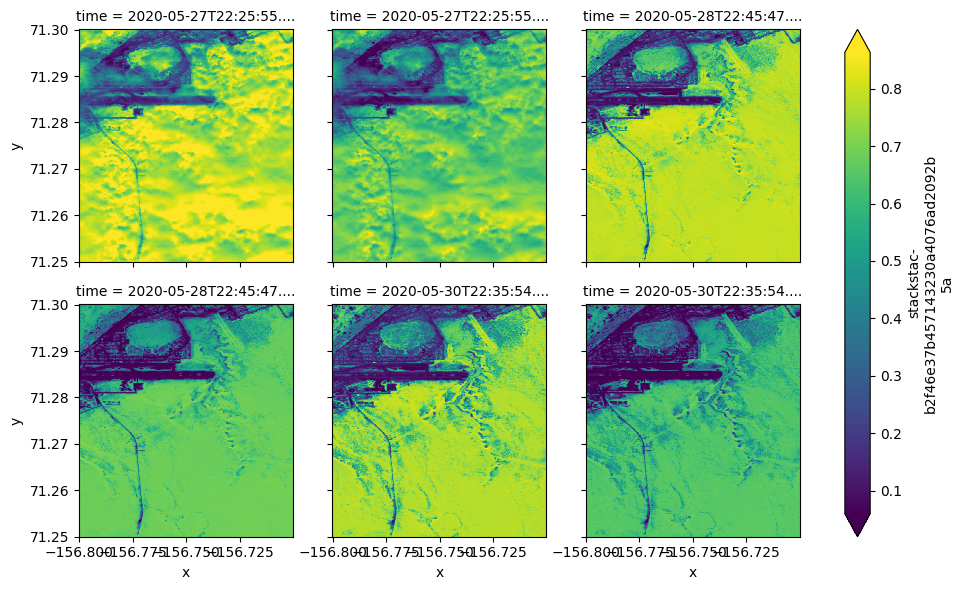

In [21]:
stack.isel(time=slice(0, 6)).squeeze().plot.imshow(col="time", col_wrap=3, robust=True)

# California Forest Observatory


This one is an example of a _static_ STAC catalog. No API server here! Just a plain ol' JSON file in cloud storage, with links to other JSON files. We lose a lot of the rich interactivity we had with STAC APIs, but we can still manually navigate the catalog to learn about the items within it, and extract URLs to associated data assets.

Open this in your web browser:
https://storage.googleapis.com/cfo-public/catalog.json

In [ ]:
uri = 'https://storage.googleapis.com/cfo-public/catalog.json'
catalog = Client.open(uri)
catalog

In [ ]:
collections = catalog.get_all_collections()
for collection in collections:
    print(f'[{collection.id}]: {collection.title}')

In [41]:
wildfire_collection = catalog.get_collection('wildfire').get_items()

In [ ]:
wildfire_items = [item for item in wildfire_collection]
wildfire_items

In [ ]:
list(wildfire_items)[0]

In [ ]:
wildfire_assets = catalog \
    .get_collection('wildfire') \
    .get_item('California-Wildfire-BurnProbability-2020-Summer-00010m') \
    .assets
wildfire_assets

In [ ]:
burn_probability_asset = wildfire_assets['BurnProbability']
burn_probability_asset

In [ ]:
href = catalog \
    .get_collection('wildfire') \
    .get_item('California-Wildfire-BurnProbability-2020-Summer-00010m') \
    .assets['BurnProbability'] \
    .href
href

In [ ]:
ds = xr.open_dataset(href, engine='rasterio', chunks={}).band_data
ds